# Overview
In this notebook, I'm trying to recreate a classification scheme for a social media app that takes a short sentence from a user as an input, and apply multi-labels based on the sentence. 

This is difficult to do because while the number of words a user write can vary quite a bit, the app's nature encourages short one sentence inputs, and sometimes it can be as short as only 1 word. 

The data was gathered manually from the app, and the multi-label targets were also classified by me (lots of subjectivity, I know...). I am trying to classify 5 different labels concurrently:
1. **Pets** - sentence implies it's pet related
2. **Secrets** - the nature of the app encourages people to share their secrets
3. **Happy** - user sounds happy
4. **Sad** - user sounds sad
5. **Seasonal** - user said something seasonally related

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from mpl_toolkits.mplot3d import Axes3D

from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline,FeatureUnion

from sklearn.base import BaseEstimator,TransformerMixin

## For a multi-label classification problem, we need to feed in a binary matrix of labels. I have manually labeled the data set.

In [2]:
df = pd.read_excel('data.xlsx')
np.random.seed(seed=1)

# Shuffling our data first
df = df.iloc[np.random.permutation(len(df))]
df.reset_index(drop=True,inplace=True)

# Separating our features and targets, i.e. 5 different types of independent labels
features = df['Sentence']
targets = df.ix[:,-5:]

# Let's look at the first 5 sample data points
df.head()

,Sentence,Pets,Secrets,Happy,Sad,Seasonal
0,You don't want your boyfriend to have female f...,0,1,0,1,0
1,"He rolled over and said ""Since you're having m...",0,1,0,1,0
2,Who has had a 3some,0,0,0,0,0
3,I love older women,0,1,0,0,0
4,Had to go home early from work because of a li...,0,0,0,0,0


## Let's start with an algorithm that is multi-label ready out of the box from SciKit-Learn
I'm using the handy pipeline function to do text vectorization and model fitting in one go. This is useful for repeatability. Only several algorithms are multi-label ready out of the box from SciKit-Learn, RandomForest is one of them.

At the end of each model fitting, I will test it out with the following sentences:
* **I love my life**
    * Secrets and Happy
* **I hate my life**
    * Secrets and Sad
* **I really want to adopt a dog.**
    * Secrets and Pets
* **This year's Christmas will be AWESOME!**
    * Happy and Seasonal
* **Ask me anything**
    * No labels should be tagged

In [3]:
sample = ['I love my life',
          'I hate my life',
          'I really want to adopt a dog.',
          'This year\'s Christmas will be AWESOME!',
          'Ask me anything']

In [4]:
pipe = Pipeline([('CountVec',CountVectorizer(ngram_range=(1,2),stop_words='english')),
                 ('model',RandomForestClassifier(random_state=1))])

pred = cross_val_predict(pipe,features,targets)

print classification_report(targets,pred,target_names=df.columns[-5:])

pipe.fit(features,targets)

sample_predictions = pipe.predict(pd.Series(sample))

tempdf = pd.DataFrame(sample_predictions,columns=df.columns[-5:])
tempdf['Sample Sentence'] = sample
tempdf

             precision    recall  f1-score   support

       Pets       0.00      0.00      0.00        10
    Secrets       0.67      0.17      0.27        59
      Happy       0.00      0.00      0.00        32
        Sad       0.25      0.03      0.05        36
   Seasonal       1.00      0.10      0.18        10

avg / total       0.40      0.08      0.13       147



C:\Users\leungr1\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


,Pets,Secrets,Happy,Sad,Seasonal,Sample Sentence
0,0.0,1.0,0.0,0.0,0.0,I love my life
1,0.0,0.0,0.0,0.0,0.0,I hate my life
2,0.0,1.0,0.0,0.0,0.0,I really want to adopt a dog.
3,0.0,0.0,0.0,0.0,0.0,This year's Christmas will be AWESOME!
4,0.0,0.0,0.0,0.0,0.0,Ask me anything


RandomForest didn't do so well as you can see from the classification report and the mislabeling of the sample sentences.

## Let's try a Naive Bayes algorithm, which is commonly used for text classification
Naive Bayes algorithms in SK-Learn are not multi-label ready out of the box. However, we can wrap that into a OneVsRest class to do multi-label classification.

In [5]:
# Naive Bayes algorithms need to be wrapped in a OneVsRest class in order to do multi-label classification.
pipe = Pipeline([('CountVec',CountVectorizer(ngram_range=(1,2),stop_words='english')),
                 ('model',OneVsRestClassifier(MultinomialNB()))])

pred = cross_val_predict(pipe,features,targets)

print classification_report(targets,pred,target_names=df.columns[-5:])

pipe.fit(features,targets)

sample_predictions = pipe.predict(pd.Series(sample))

tempdf = pd.DataFrame(sample_predictions,columns=df.columns[-5:])
tempdf['Sample Sentence'] = sample
tempdf

             precision    recall  f1-score   support

       Pets       1.00      0.60      0.75        10
    Secrets       0.64      0.83      0.73        59
      Happy       0.26      0.19      0.22        32
        Sad       0.44      0.31      0.36        36
   Seasonal       1.00      0.10      0.18        10

avg / total       0.56      0.50      0.49       147



,Pets,Secrets,Happy,Sad,Seasonal,Sample Sentence
0,0,1,1,0,0,I love my life
1,0,1,0,1,0,I hate my life
2,1,1,0,1,0,I really want to adopt a dog.
3,0,0,1,0,1,This year's Christmas will be AWESOME!
4,0,0,0,0,0,Ask me anything


A MultinomialNB did a lot better than RandomForest, even though the scores still have a lot of room for improvement. And also, the sample sentence labeling was what I expected them to be, except that "I really want to adopt a dog" was labeled with sad to my surprise. 

MultinomialNB is used on data that are positive integers, which is perfect in our case since our CountVectorizer gives us counts of words. 

## Let's try a a different NB algorithm that focuses on binary inputs
Another variation of NB is BernoulliNB, which follows a Bernoulli distribution. It simulates the probability of a binary output, i.e. 1 or 0. Let's adjust our CountVectorizer to output in binary also.

In [6]:
pipe = Pipeline([('CountVec',CountVectorizer(ngram_range=(1,2),stop_words='english',binary=True)),
                 ('model',OneVsRestClassifier(BernoulliNB()))])

pred = cross_val_predict(pipe,features,targets)

print classification_report(targets,pred,target_names=df.columns[-5:])

pipe.fit(features,targets)

sample_predictions = pipe.predict(pd.Series(sample))

tempdf = pd.DataFrame(sample_predictions,columns=df.columns[-5:])
tempdf['Sample Sentence'] = sample
tempdf

             precision    recall  f1-score   support

       Pets       0.00      0.00      0.00        10
    Secrets       0.51      0.36      0.42        59
      Happy       0.00      0.00      0.00        32
        Sad       0.00      0.00      0.00        36
   Seasonal       0.00      0.00      0.00        10

avg / total       0.21      0.14      0.17       147



,Pets,Secrets,Happy,Sad,Seasonal,Sample Sentence
0,0,1,0,0,0,I love my life
1,0,1,0,0,0,I hate my life
2,0,1,0,0,0,I really want to adopt a dog.
3,0,1,0,0,0,This year's Christmas will be AWESOME!
4,0,1,0,0,0,Ask me anything


That did not work so well...

## Let's try one more NB, GaussianNB
Some algorithms cannot directly take in a sparse matrix, which is what CountVectorizer outputs. To continue using a pipeline, we will need to write a custom transformer, sandwiched between the CountVectorizer and our classifer, to transform our sparse matrix into an array.

In [7]:
# GaussianNB cannot take in a sparse matrix, so a custom transformer is needed to convert the CountVectorizer output
# into an array
class ArrayTransformer(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X,y=None):
        return X.toarray()

pipe = Pipeline([('CountVec',CountVectorizer(ngram_range=(1,2),stop_words='english')),
                 ('ArrayTransform',ArrayTransformer()),
                 ('model',OneVsRestClassifier(GaussianNB()))
                ])

pred = cross_val_predict(pipe,features,targets)

print classification_report(targets,pred,target_names=df.columns[-5:])

pipe.fit(features,targets)
sample_predictions = pipe.predict(pd.Series(sample))

tempdf = pd.DataFrame(sample_predictions,columns=df.columns[-5:])
tempdf['Sample Sentence'] = sample
tempdf

             precision    recall  f1-score   support

       Pets       0.29      0.70      0.41        10
    Secrets       0.81      0.75      0.78        59
      Happy       0.28      0.47      0.35        32
        Sad       0.39      0.64      0.48        36
   Seasonal       0.21      0.50      0.29        10

avg / total       0.52      0.64      0.56       147



,Pets,Secrets,Happy,Sad,Seasonal,Sample Sentence
0,0,0,1,1,0,I love my life
1,0,1,0,1,0,I hate my life
2,1,1,0,1,0,I really want to adopt a dog.
3,0,0,1,0,1,This year's Christmas will be AWESOME!
4,0,0,0,0,0,Ask me anything


Looking at the f1-score and the labeling results of our sample sentences, it seems like GaussianNB was the best performing one! However, note that I did not do rigorous testing such as nested cross validation, using a different vectorizer such as TF-IDF, and hyperparameters tuning (n-grams, binary counts, etc.), which could potentially improve our model. Also, the sentence "I love my life" was not labeled as a secret as expected.

### Adding a new feature to try to improve the model

Actually, the best way to improve a model is not fine tuning the hyper parameters. It's getting more relevant data and feature engineering. I don't have easy access to more data, but let's try to add a new feature. The easiest one that comes to mind is including the word count. Perhaps the number of words in each user input can help us separate the labels better?

Let's write another custom transformer to add the word count to our feature space.

In [8]:
class AddWordCount(BaseEstimator,TransformerMixin):
    def CountWords(self,sentence):
        return len(sentence.split(' '))
    def fit(self,df,y=None):
        return self
    def transform(self,series,y=None):
        # Need to reshaped in order to be concatenated with our CountVec 
        return np.array(series.apply(self.CountWords)).reshape(-1,1)

In [9]:
pipe = Pipeline([('getFeatures',FeatureUnion([('addWordCount',AddWordCount()),
                                              ('CountVec',CountVectorizer(stop_words='english'))])),
                 ('ArrayTransform',ArrayTransformer()),
                 ('model',OneVsRestClassifier(GaussianNB()))
                ])

pred = cross_val_predict(pipe,features,targets)

print classification_report(targets,pred,target_names=df.columns[-5:])

pipe.fit(features,targets)

sample_predictions = pipe.predict(pd.Series(sample))

tempdf = pd.DataFrame(sample_predictions,columns=df.columns[-5:])
tempdf['Sample Sentence'] = sample
tempdf

             precision    recall  f1-score   support

       Pets       0.29      0.70      0.41        10
    Secrets       0.81      0.75      0.78        59
      Happy       0.28      0.50      0.36        32
        Sad       0.39      0.61      0.47        36
   Seasonal       0.21      0.50      0.29        10

avg / total       0.52      0.64      0.55       147



,Pets,Secrets,Happy,Sad,Seasonal,Sample Sentence
0,0,0,1,1,0,I love my life
1,0,1,0,1,0,I hate my life
2,1,1,0,1,0,I really want to adopt a dog.
3,0,0,1,0,1,This year's Christmas will be AWESOME!
4,0,0,0,0,0,Ask me anything


Adding the word count feature doesn't seem like it did anything...

## Visualize our data with dimensionality reduction
Visualizing data is often useful in helping us understnad how best to divide our data, but this is often a difficult task for text features. Each word is considered a dimension in terms of our feature space, and our data set has around 500 dimensions after our vectorizer.

One way to visualize our data is to reduce the dimensions via processes like Principal Component Analysis (PCA). Let's visualize how our 5 different labels look like when we reduce 500 dimensions down to 3.

In [10]:
from sklearn.decomposition import PCA
%matplotlib inline

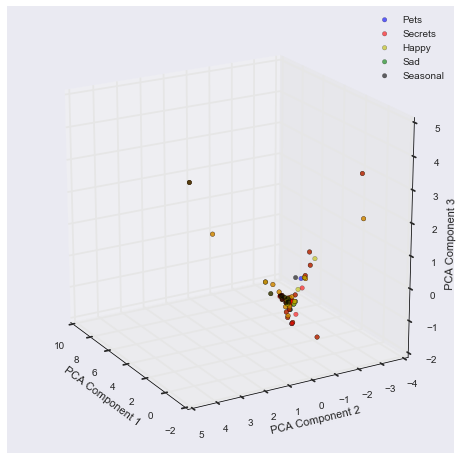

In [11]:
vec = CountVectorizer(ngram_range=(1,2),stop_words='english')
dtm = vec.fit_transform(features)

decompose = PCA(n_components=3,random_state=1)
components = decompose.fit_transform(dtm.toarray())

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1, projection='3d')

pets_mask = df['Pets'] == 1
secrets_mask = df['Secrets'] == 1
happy_mask = df['Happy'] == 1
sad_mask = df['Sad'] == 1
seasonal_mask = df['Seasonal'] == 1

pets_components = components[np.array(pets_mask)]
secrets_components = components[np.array(secrets_mask)]
happy_components = components[np.array(happy_mask)]
sad_components = components[np.array(sad_mask)]
seasonal_components = components[np.array(seasonal_mask)]

all_components = [pets_components,secrets_components,happy_components,sad_components,seasonal_components]
c = ['b','r','y','g','k']
labels = ['Pets','Secrets','Happy','Sad','Seasonal']

for component,c,label in zip(all_components,c,labels):
    ax.scatter(xs=component[:,0],ys=component[:,1],zs=component[:,2],alpha=0.6,c=c,
               label=label)

ax.view_init(20,150); ax.legend()
ax.set_xlabel('PCA Component 1'); ax.set_ylabel('PCA Component 2'); ax.set_zlabel('PCA Component 3')
plt.show()

Even with 3 dimensions, it doesn't seem like there are any clear boundaries or obvious clusters. For sample points with multiple labels, you will see colors blending into each other since I made the data points transparent. Perhaps more dimensions are needed to separate our data, but visually, we are limited to 3 dimensions only.

# Conclusion:

I tried several classifiers and played around with some feature engineering (word frequency counts vs binary, and adding number of words). 

The classification results aren't exactly stellar and obviously there are lots of room for improvement. Having more data and more advanced model selection techniques such as nested cross validation and hyperparameters tuning can potentially yield better accuracy results. 

On a bright note, given the small amount of training data available, I am surprised that the MultinomailNB and GaussianNB model were able to correctly tag the multi-labels of the sample sentences. There are many more aspects of the social media app that I'm not considering when building this model, which I believe could be used as features for more accurate classification. 

With accurate multi-label classification, I believe the social app can use the results to recommend items that the user likes.